In [1]:
!lscpu |grep 'Model name'
!nvidia-smi
!pip install ax-platform

Model name:                      Intel(R) Xeon(R) CPU @ 2.30GHz
Mon Mar 20 16:57:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    30W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                        

In [2]:
import pandas as pd
from ax import *
import torch

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable

from ax.service.utils.report_utils import exp_to_df
from ax.runners.synthetic import SyntheticRunner
from ax.metrics.noisy_function import GenericNoisyFunctionMetric

# Analysis utilities, including a method to evaluate hypervolumes
from ax.modelbridge.modelbridge_utils import observed_hypervolume

from botorch.test_functions.multi_objective import DTLZ4

In [3]:
tkwargs = {
    "dtype": torch.double, 
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

In [4]:
dim = 30
problem = DTLZ4(num_objectives=2, dim=dim, negate=False).to(**tkwargs)

param_names = [f"x{i}" for i in range(dim)]

def f1(x) -> float:
        x_sorted = [x[p_name] for p_name in param_names] # Obtiene los parámetros a evaluar
        return float(problem(torch.tensor(x_sorted, **tkwargs).clamp(0., 1.))[0]) # Evalúa los parámetros en el primer objetivo
    
def f2(x) -> float:
        x_sorted = [x[p_name] for p_name in param_names]
        return float(problem(torch.tensor(x_sorted, **tkwargs).clamp(0., 1.))[1]) # Evalúa los parámetros en el segundo objetivo

metric_a = GenericNoisyFunctionMetric("a", f=f1, noise_sd=0.0, lower_is_better=True)
metric_b = GenericNoisyFunctionMetric("b", f=f2, noise_sd=0.0, lower_is_better=True)

In [5]:
search_space = SearchSpace(
    parameters=[
        RangeParameter(name=param_name, lower=0, upper=1, parameter_type=ParameterType.FLOAT)
        for param_name in param_names
        ]
)

mo = MultiObjective(
    objectives=[Objective(metric=metric_a), Objective(metric=metric_b)],
)

objective_thresholds = [
    ObjectiveThreshold(metric=metric, bound=val, relative=False)
    for metric, val in zip(mo.metrics, problem.ref_point)
]

optimization_config = MultiObjectiveOptimizationConfig(
    objective=mo,
    objective_thresholds=objective_thresholds,
)

In [6]:
N_INIT = 2 * (dim + 1)
N_BATCH = 10
BATCH_SIZE = 1

def build_experiment():
    experiment = Experiment(
        name="pareto_experiment",
        search_space=search_space,
        optimization_config=optimization_config,
        runner=SyntheticRunner(),
    )
    return experiment

def initialize_experiment(experiment):
    sobol = Models.SOBOL(search_space=experiment.search_space)

    for _ in range(N_INIT):
        experiment.new_trial(sobol.gen(1)).run()

    return experiment.fetch_data()

In [7]:
import time

executions = 10
execution_times = []
all_df = []
all_outcomes = []

for exec in range(executions):
  start_time = time.time()

  experiment = build_experiment()
  data = initialize_experiment(experiment)

  hv_list = []
  model = None
  for i in range(N_BATCH):   
      model = Models.FULLYBAYESIANMOO(
          experiment=experiment, 
          data=data,
          num_samples=16,
          warmup_steps=32,
          torch_device=tkwargs["device"],
      )
      generator_run = model.gen(BATCH_SIZE)
      trial = experiment.new_trial(generator_run=generator_run)
      trial.run()
      data = Data.from_multiple_data([data, trial.fetch_data()])
      
      exp_df = exp_to_df(experiment)
      outcomes = np.array(exp_df[['a', 'b']], dtype=np.double)
      try:
          hv = observed_hypervolume(modelbridge=model)
      except:
          hv = 0
          print("Failed to compute hv")
      hv_list.append(hv)
      print(f"Execution: {exec + 1}, Iteration: {i + 1}, HV: {hv}")

  execution_times.append(time.time() - start_time)

  all_df.append(exp_to_df(experiment).sort_values(by=["trial_index"]))
  all_outcomes.append(np.array(exp_to_df(experiment)[['a', 'b']], dtype=np.double))

Sample: 100%|██████████| 48/48 [00:17,  2.75it/s, step size=4.28e-01, acc. prob=0.733]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 1, HV: 0.0


Sample: 100%|██████████| 48/48 [00:17,  2.82it/s, step size=3.88e-01, acc. prob=0.319]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 2, HV: 0.0


Sample: 100%|██████████| 48/48 [00:17,  2.77it/s, step size=3.05e-01, acc. prob=0.869]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 3, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.62it/s, step size=2.26e-01, acc. prob=0.912]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 4, HV: 0.0


Sample: 100%|██████████| 48/48 [00:17,  2.71it/s, step size=3.72e-01, acc. prob=0.623]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 5, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.54it/s, step size=4.89e-01, acc. prob=0.202]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 6, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.62it/s, step size=3.57e-01, acc. prob=0.736]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 7, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.61it/s, step size=1.45e-01, acc. prob=0.823]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 8, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.54it/s, step size=1.63e-01, acc. prob=0.932]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 9, HV: 0.0


Sample: 100%|██████████| 48/48 [00:19,  2.46it/s, step size=1.40e-01, acc. prob=0.922]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 1, Iteration: 10, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.64it/s, step size=4.77e-01, acc. prob=0.675]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 1, HV: 0.0


Sample: 100%|██████████| 48/48 [00:17,  2.74it/s, step size=1.97e-01, acc. prob=0.936]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 2, HV: 0.0


Sample: 100%|██████████| 48/48 [00:17,  2.75it/s, step size=1.48e-01, acc. prob=0.967]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 3, HV: 0.0


Sample: 100%|██████████| 48/48 [00:19,  2.46it/s, step size=2.72e-01, acc. prob=0.451]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 4, HV: 0.0


Sample: 100%|██████████| 48/48 [00:12,  3.78it/s, step size=3.76e-01, acc. prob=0.076]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 5, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.65it/s, step size=2.73e-01, acc. prob=0.871]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 6, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.66it/s, step size=4.40e-01, acc. prob=0.723]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 7, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.66it/s, step size=3.43e-01, acc. prob=0.435]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 8, HV: 0.0


Sample: 100%|██████████| 48/48 [00:17,  2.79it/s, step size=3.67e-01, acc. prob=0.639]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 9, HV: 0.0


Sample: 100%|██████████| 48/48 [00:19,  2.52it/s, step size=2.70e-01, acc. prob=0.839]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 2, Iteration: 10, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.60it/s, step size=2.80e-01, acc. prob=0.900]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 1, HV: 0.0


Sample: 100%|██████████| 48/48 [00:17,  2.71it/s, step size=1.16e-01, acc. prob=0.662]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 2, HV: 0.0


Sample: 100%|██████████| 48/48 [00:19,  2.42it/s, step size=2.65e-01, acc. prob=0.932]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 3, HV: 0.0


Sample: 100%|██████████| 48/48 [00:21,  2.23it/s, step size=1.55e-01, acc. prob=0.839]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 4, HV: 0.0


Sample: 100%|██████████| 48/48 [00:21,  2.21it/s, step size=1.71e-01, acc. prob=0.949]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 5, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.32it/s, step size=3.63e-01, acc. prob=0.813]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 6, HV: 0.0


Sample: 100%|██████████| 48/48 [00:22,  2.18it/s, step size=4.46e-01, acc. prob=0.356]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 7, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.29it/s, step size=2.51e-01, acc. prob=0.843]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 8, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.34it/s, step size=2.48e-01, acc. prob=0.689]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 3, Iteration: 9, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.32it/s, step size=1.58e-01, acc. prob=0.965]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/service/utils/report_utils.py:746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results[FEASIBLE_COL_NAME] = _is_row_feasible(
/usr/lo

Execution: 3, Iteration: 10, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.62it/s, step size=3.87e-01, acc. prob=0.496]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 1, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.61it/s, step size=2.28e-01, acc. prob=0.888]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 2, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.59it/s, step size=3.04e-01, acc. prob=0.700]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 3, HV: 0.0


Sample: 100%|██████████| 48/48 [00:16,  2.93it/s, step size=5.93e-01, acc. prob=0.137]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 4, HV: 0.0


Sample: 100%|██████████| 48/48 [00:19,  2.52it/s, step size=2.98e-01, acc. prob=0.810]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 5, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.40it/s, step size=1.51e-01, acc. prob=0.875]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 6, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.56it/s, step size=2.60e-01, acc. prob=0.526]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 7, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.53it/s, step size=3.39e-01, acc. prob=0.305]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 8, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.54it/s, step size=3.15e-01, acc. prob=0.821]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 9, HV: 0.0


Sample: 100%|██████████| 48/48 [00:13,  3.52it/s, step size=2.71e-01, acc. prob=0.187]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 4, Iteration: 10, HV: 0.0


Sample: 100%|██████████| 48/48 [00:19,  2.45it/s, step size=3.89e-01, acc. prob=0.645]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 1, HV: 0.0


Sample: 100%|██████████| 48/48 [00:19,  2.45it/s, step size=4.47e-01, acc. prob=0.509]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 2, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.58it/s, step size=2.86e-01, acc. prob=0.819]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 3, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.35it/s, step size=6.15e-01, acc. prob=0.287]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 4, HV: 0.0


Sample: 100%|██████████| 48/48 [00:19,  2.48it/s, step size=4.01e-01, acc. prob=0.846]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 5, HV: 0.0


Sample: 100%|██████████| 48/48 [00:19,  2.48it/s, step size=4.24e-01, acc. prob=0.682]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 6, HV: 0.0


Sample: 100%|██████████| 48/48 [00:19,  2.41it/s, step size=1.18e-01, acc. prob=0.967]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 7, HV: 0.0


Sample: 100%|██████████| 48/48 [00:19,  2.43it/s, step size=3.19e-01, acc. prob=0.844]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 8, HV: 0.0


Sample: 100%|██████████| 48/48 [00:19,  2.50it/s, step size=4.17e-01, acc. prob=0.591]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 9, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.55it/s, step size=3.17e-01, acc. prob=0.692]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 5, Iteration: 10, HV: 0.0


Sample: 100%|██████████| 48/48 [00:17,  2.68it/s, step size=4.30e-01, acc. prob=0.604]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 1, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.55it/s, step size=3.02e-01, acc. prob=0.515]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 2, HV: 0.0


Sample: 100%|██████████| 48/48 [00:17,  2.73it/s, step size=3.01e-01, acc. prob=0.831]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 3, HV: 0.0


Sample: 100%|██████████| 48/48 [00:19,  2.45it/s, step size=2.85e-01, acc. prob=0.858]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 4, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.60it/s, step size=1.84e-01, acc. prob=0.955]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 5, HV: 0.0


Sample: 100%|██████████| 48/48 [00:19,  2.42it/s, step size=2.05e-01, acc. prob=0.764]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 6, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.55it/s, step size=1.74e-01, acc. prob=0.934]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 7, HV: 0.0


Sample: 100%|██████████| 48/48 [00:19,  2.48it/s, step size=2.27e-01, acc. prob=0.868]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 8, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.57it/s, step size=4.09e-01, acc. prob=0.221]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 9, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.34it/s, step size=1.44e-01, acc. prob=0.975]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 6, Iteration: 10, HV: 0.0


Sample: 100%|██████████| 48/48 [00:17,  2.68it/s, step size=4.47e-01, acc. prob=0.651]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 1, HV: 0.0


Sample: 100%|██████████| 48/48 [00:17,  2.68it/s, step size=2.86e-01, acc. prob=0.747]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 2, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.59it/s, step size=3.99e-01, acc. prob=0.361]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 3, HV: 0.0


Sample: 100%|██████████| 48/48 [00:15,  3.01it/s, step size=6.11e-01, acc. prob=0.052]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 4, HV: 0.0


Sample: 100%|██████████| 48/48 [00:19,  2.47it/s, step size=3.73e-01, acc. prob=0.732]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 5, HV: 0.0


Sample: 100%|██████████| 48/48 [00:16,  2.95it/s, step size=6.16e-01, acc. prob=0.080]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 6, HV: 0.0


Sample: 100%|██████████| 48/48 [00:19,  2.52it/s, step size=4.23e-01, acc. prob=0.836]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 7, HV: 0.0


Sample: 100%|██████████| 48/48 [00:17,  2.68it/s, step size=1.14e-01, acc. prob=0.951]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 8, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.58it/s, step size=4.59e-01, acc. prob=0.739]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 9, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.66it/s, step size=4.72e-01, acc. prob=0.084]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 7, Iteration: 10, HV: 0.0


Sample: 100%|██████████| 48/48 [00:19,  2.50it/s, step size=3.18e-01, acc. prob=0.873]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 1, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.58it/s, step size=4.66e-01, acc. prob=0.671]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 2, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.39it/s, step size=3.76e-01, acc. prob=0.852]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 3, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.35it/s, step size=3.37e-01, acc. prob=0.809]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 4, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.30it/s, step size=4.47e-01, acc. prob=0.711]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 5, HV: 0.0


Sample: 100%|██████████| 48/48 [00:22,  2.15it/s, step size=5.03e-01, acc. prob=0.436]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 6, HV: 0.0


Sample: 100%|██████████| 48/48 [00:22,  2.17it/s, step size=4.90e-01, acc. prob=0.526]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 7, HV: 0.0


Sample: 100%|██████████| 48/48 [00:19,  2.45it/s, step size=3.31e-01, acc. prob=0.689]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 8, HV: 0.0


Sample: 100%|██████████| 48/48 [00:21,  2.27it/s, step size=4.14e-01, acc. prob=0.773]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 9, HV: 0.0


Sample: 100%|██████████| 48/48 [00:21,  2.20it/s, step size=1.95e-01, acc. prob=0.776]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 8, Iteration: 10, HV: 0.0


Sample: 100%|██████████| 48/48 [00:21,  2.22it/s, step size=3.55e-01, acc. prob=0.410]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 1, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.36it/s, step size=2.91e-01, acc. prob=0.476]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 2, HV: 0.0


Sample: 100%|██████████| 48/48 [00:19,  2.44it/s, step size=3.33e-01, acc. prob=0.942]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 3, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.62it/s, step size=6.00e-01, acc. prob=0.085]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 4, HV: 0.0


Sample: 100%|██████████| 48/48 [00:21,  2.24it/s, step size=2.81e-01, acc. prob=0.918]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 5, HV: 0.0


Sample: 100%|██████████| 48/48 [00:21,  2.24it/s, step size=3.27e-01, acc. prob=0.874]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 6, HV: 0.0


Sample: 100%|██████████| 48/48 [00:21,  2.27it/s, step size=3.69e-01, acc. prob=0.836]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 7, HV: 0.0


Sample: 100%|██████████| 48/48 [00:21,  2.28it/s, step size=2.35e-01, acc. prob=0.789]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 8, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.32it/s, step size=2.08e-01, acc. prob=0.849]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 9, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.29it/s, step size=3.72e-01, acc. prob=0.587]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 9, Iteration: 10, HV: 0.0


Sample: 100%|██████████| 48/48 [00:17,  2.76it/s, step size=5.87e-01, acc. prob=0.305]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 1, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.60it/s, step size=5.00e-01, acc. prob=0.546]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 2, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.62it/s, step size=2.18e-01, acc. prob=0.928]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 3, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.30it/s, step size=4.59e-01, acc. prob=0.444]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 4, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.36it/s, step size=2.47e-01, acc. prob=0.786]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 5, HV: 0.0


Sample: 100%|██████████| 48/48 [00:16,  2.86it/s, step size=3.31e-01, acc. prob=0.306]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 6, HV: 0.0


Sample: 100%|██████████| 48/48 [00:20,  2.35it/s, step size=1.38e-01, acc. prob=0.943]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 7, HV: 0.0


Sample: 100%|██████████| 48/48 [00:23,  2.07it/s, step size=2.43e-01, acc. prob=0.421]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 8, HV: 0.0


Sample: 100%|██████████| 48/48 [00:18,  2.56it/s, step size=2.93e-01, acc. prob=0.592]
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 9, HV: 0.0


Sample: 100%|██████████| 48/48 [00:16,  2.95it/s, step size=3.46e-01, acc. prob=0.087]
/usr/local/lib/python3.9/dist-packages/botorch/optim/initializers.py:224: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/ax/modelbridge/modelbridge_utils.py:852: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  warnings.warn(


Execution: 10, Iteration: 10, HV: 0.0


<ipython-input-8-bd6ef215e9e8>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('viridis')


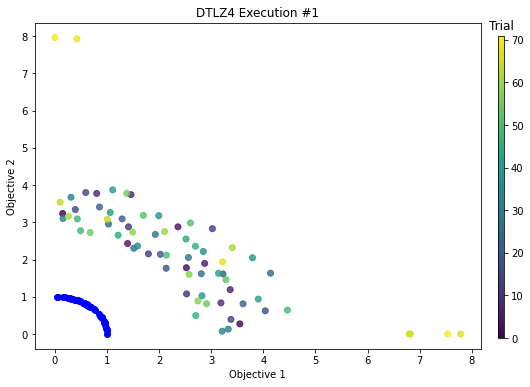

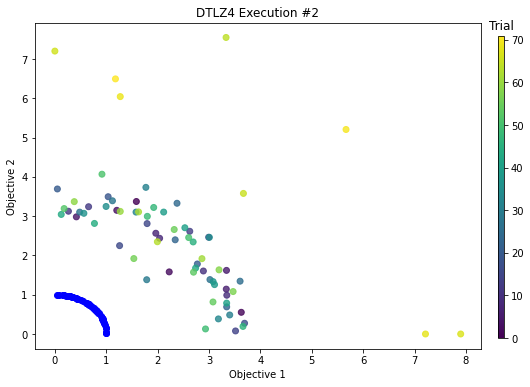

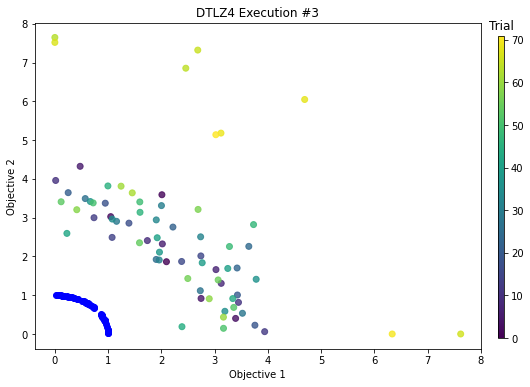

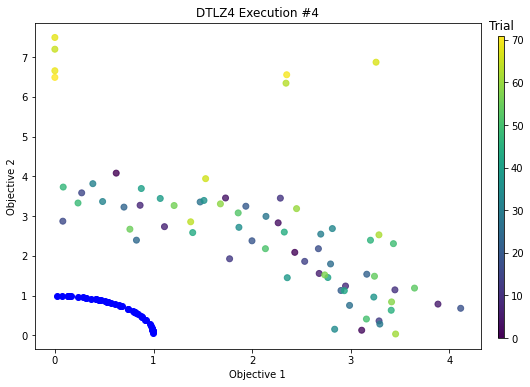

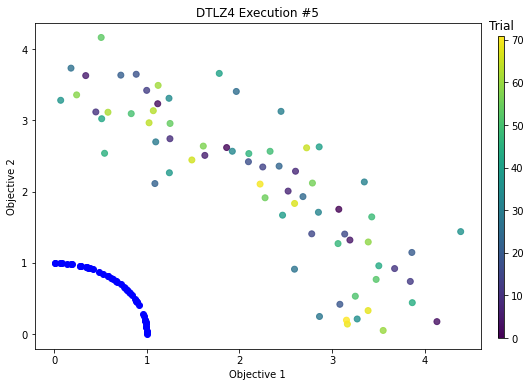

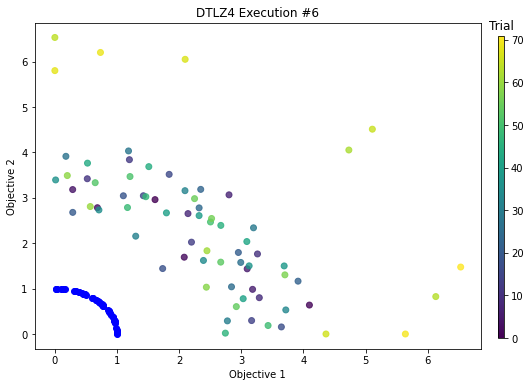

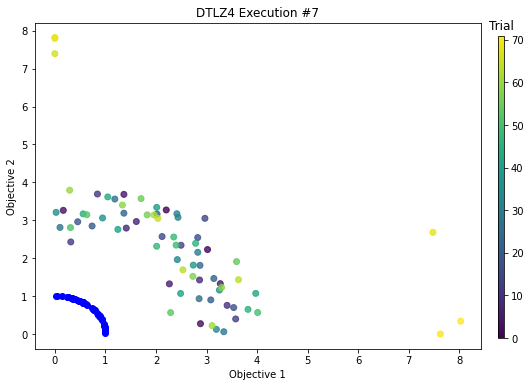

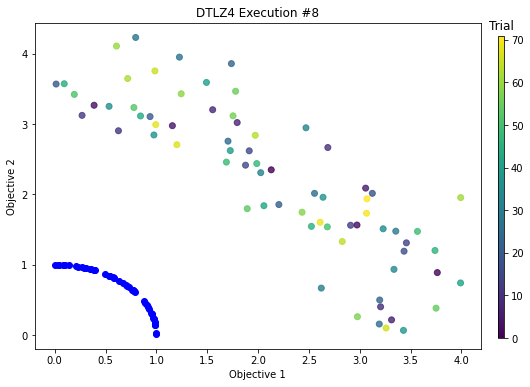

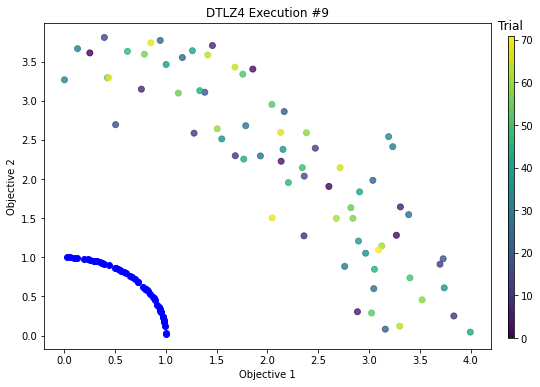

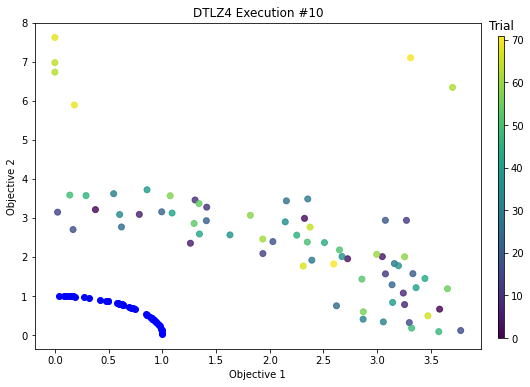

In [8]:
from torch import Tensor
%matplotlib inline

for exec in range(executions):
  fig, axes = plt.subplots(1, 1, figsize=(8,6))

  pareto_front = Tensor.cpu(problem.gen_pareto_front(50))
  axes.scatter(pareto_front[:, 0], pareto_front[:, 1], color='b')


  cm = plt.cm.get_cmap('viridis')
  batch_number = all_df[exec].trial_index.values
  sc = axes.scatter(all_outcomes[exec][:, 0], all_outcomes[exec][:,1], c=batch_number, alpha=0.8)
  axes.set_title(f'DTLZ4 Execution #{exec + 1}')
  axes.set_xlabel("Objective 1")
  axes.set_ylabel("Objective 2")
  norm = plt.Normalize(batch_number.min(), batch_number.max())
  sm =  ScalarMappable(norm=norm, cmap=cm)
  fig.subplots_adjust(right=0.9)
  cbar_ax = fig.add_axes([0.93, 0.15, 0.01, 0.7])
  cbar = fig.colorbar(sm, cax=cbar_ax)
  cbar.ax.set_title("Trial")

Execution times: [417.78660846 408.99233127 439.45802379 410.36713338 404.23931193
 424.21122456 391.70595169 435.77430987 431.73726439 425.56330132]
Average execution time: 418.9835460662842


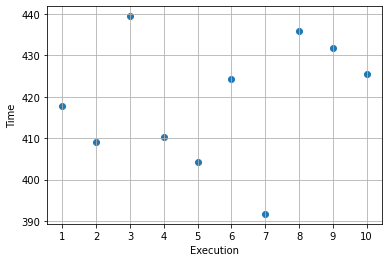

In [9]:
%matplotlib inline
fig, axes = plt.subplots(1, 1)
plt.xticks(np.arange(1, executions + 1))

axes.scatter(np.arange(1, executions + 1), np.array(execution_times))
axes.grid(True)
axes.set_xlabel("Execution")
axes.set_ylabel("Time")

print("Execution times:", np.array(execution_times))
print("Average execution time:", np.array(execution_times).sum()/len(execution_times))

In [10]:
print(all_df)

[    trial_index arm_name trial_status generation_method             a  \
0             0      0_0      RUNNING             Sobol  1.500628e-01   
1             1      1_0      RUNNING             Sobol  3.548844e+00   
2             2      2_0      RUNNING             Sobol  2.523303e+00   
3             3      3_0      RUNNING             Sobol  2.361551e+00   
4             4      4_0      RUNNING             Sobol  1.394935e+00   
..          ...      ...          ...               ...           ...   
67           67     67_0      RUNNING  FullyBayesianMOO  7.785775e+00   
68           68     68_0      RUNNING  FullyBayesianMOO  3.216189e+00   
69           69     69_0      RUNNING  FullyBayesianMOO  4.210645e-01   
70           70     70_0      RUNNING  FullyBayesianMOO  4.877247e-16   
71           71     71_0      RUNNING  FullyBayesianMOO  7.534823e+00   

           b  is_feasible        x0        x1        x2  ...       x20  \
0   3.235157        False  0.970492  0.674847  0